<h1 id="weather_station_clustering" align="center"> Clustering Ghanaian households based on their expenditure patterns</h1>
<hr>

#### 1.4 Model Definition - Part 2

#### SECOND PART  - DEEP LEARNING ALGORITHMS

In this second part (using deep learning frameworks), we will consider the following algorithms and compare their results

a. kmeans clustering algorithm

b. autoencoder + kmeans

c. DEC ( Deep Embedded Clustering) with autoencoder and kmeans

Importing necessary libraries

In [51]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score



Populating the interactive namespace from numpy and matplotlib


/home/jupyterlab/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'time', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [52]:
#!pip install metrics
import metrics

Also. lets import the DEC algorithm

In [54]:
!git clone https://github.com/XifengGuo/DEC-keras
!cd DEC-keras

fatal: destination path 'DEC-keras' already exists and is not an empty directory.


In [55]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

Import data

In [56]:
import pandas as pd
df = pd.read_csv('df_norm_dataframe.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)


Renaming the dataset

In [58]:
train = df
train.head()

,totfood,totalch,totclth,tothous,totfurn,tothlth,tottrsp,totcmnq,totrcre,toteduc,totmisc
0,0.869768,-0.282063,0.813326,0.597423,0.930850,0.270093,0.381865,-0.274590,-0.216681,-0.115215,0.970906
1,0.333146,-0.282063,-0.095515,3.937930,1.783318,-0.204459,-0.270768,0.137049,-0.224311,0.806321,-0.077166
2,-0.524523,-0.282063,-0.488894,0.058295,-0.199684,-0.182889,-0.331876,-0.261965,-0.265152,-0.282872,0.781011
3,0.234851,-0.282063,1.200771,0.042361,0.104170,-0.182889,0.486971,0.487875,-0.278814,-0.187837,0.737953
4,2.104382,-0.282063,0.356362,0.286199,1.399336,6.288280,-0.007448,0.594741,-0.195824,0.020165,0.877056


a. kmeans clustering algorithm

We will first apply K-Means directly to our data and divide it into 3 clusters.

In [59]:
km = KMeans(n_clusters=3)

In [60]:
x_train = train.values

In [61]:
kmeans = km.fit(x_train)

In [62]:
kmeans.labels_[0:10] #first 10 cluster labels

array([0, 0, 2, 0, 0, 2, 2, 2, 2, 0], dtype=int32)

at best we can find the optimal number of clusters

In [63]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_train, kmeans.labels_))

Silhouette Coefficient: 0.378


This silhouette score is worse than the results under HDBSCAN

####  b. kmeans + autoencoder


Now instead of directly applying K-Means on the problem, we will first use an autoencoder to decrease the dimensionality of the data and extract useful information. This will then pass on the information to the K-Means algorithm.



In [64]:
# this is our input placeholder
input_img = Input(shape=(11,)) # 11 FEATURES

# "encoded" is the encoded representation of the input  - extracting relevant information
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(11, activation='softmax')(encoded)

# "decoded" is the lossy reconstruction of the input - decoding relevant information
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='softmax')(decoded)
decoded = Dense(11)(decoded) # 11 features

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [65]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               6000      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 11)                22011     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              24000     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000500   
__________

In [66]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [67]:
autoencoder.compile(optimizer='adam', loss='mse')

Now let us train our autoencoder model.

In [68]:
train_history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=1048, validation_data=(x_train, x_train))

Train on 8922 samples, validate on 8922 samples
Epoch 1/50
8922/8922 [==============================] - 5s 616us/step - loss: 1.0001 - val_loss: 1.0000
Epoch 2/50
8922/8922 [==============================] - 5s 529us/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/50
8922/8922 [==============================] - 5s 525us/step - loss: 1.0000 - val_loss: 0.9999
Epoch 4/50
8922/8922 [==============================] - 5s 525us/step - loss: 0.9997 - val_loss: 0.9988
Epoch 5/50
8922/8922 [==============================] - 5s 525us/step - loss: 0.9962 - val_loss: 0.9889
Epoch 6/50
8922/8922 [==============================] - 5s 525us/step - loss: 0.9788 - val_loss: 0.9640
Epoch 7/50
8922/8922 [==============================] - 5s 526us/step - loss: 0.9555 - val_loss: 0.9461
Epoch 8/50
8922/8922 [==============================] - 5s 528us/step - loss: 0.9420 - val_loss: 0.9370
Epoch 9/50
8922/8922 [==============================] - 5s 526us/step - loss: 0.9338 - val_loss: 0.9296
Epoch 10/50
8922

In [69]:
pred_auto_train = autoencoder.predict(x_train) # this is x' = output of auto encoder
#pred_auto_train = encoder.predict(x_train) # this is x' = output of auto encoder

In [70]:
pred_auto_train.shape

(8922, 11)

In [71]:
kmeans_dl = km.fit(pred_auto_train)

In [81]:
kmeans_dl.labels_[0:10] #first 10 cluster labels

array([2, 2, 0, 2, 2, 0, 0, 0, 0, 2], dtype=int32)

In [72]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pred_auto_train, kmeans_dl.labels_))

Silhouette Coefficient: 0.986


In [73]:
#import numpy as np

In [78]:
XX = pred_auto_train

In [79]:
XX_df = pd.DataFrame({'totfood':XX[:,0],'totalch':XX[:,1], 'totclth':XX[:,2],'tothous':XX[:,3],'totfurn':XX[:,4], 'tothlth':XX[:,5],
                       'tottrsp':XX[:,6],'totcmnq':XX[:,7], 'totrcre':XX[:,8],'toteduc':XX[:,9],'totmisc':XX[:,10]})


In [80]:
XX_df.to_csv('XX_df.csv')

Adding labels to the data

In [82]:
XX_dfl = pd.DataFrame({'totfood':XX[:,0],'totalch':XX[:,1], 'totclth':XX[:,2],'tothous':XX[:,3],'totfurn':XX[:,4], 'tothlth':XX[:,5],
                       'tottrsp':XX[:,6],'totcmnq':XX[:,7], 'totrcre':XX[:,8],'toteduc':XX[:,9],'totmisc':XX[:,10], 'label':kmeans_dl.labels_})

Visualizing the clusters

PCA Projection to 2D

Now, let's try to visualize the cluster, although we have only one cluster. First, lets use PCA to reduce the dimension of the data to two dimensions


In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(XX_dfl)

principalDf_dbscan = pd.DataFrame(data = principalComponents
             , columns = ['C1', 'C2'])

In [84]:
principalDf_dbscan['label'] = XX_dfl.label

In [85]:
principalDf_dbscan.head(2)

,C1,C2,label
0,1.698424,-0.292963,2
1,1.698424,-0.292963,2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'C2')

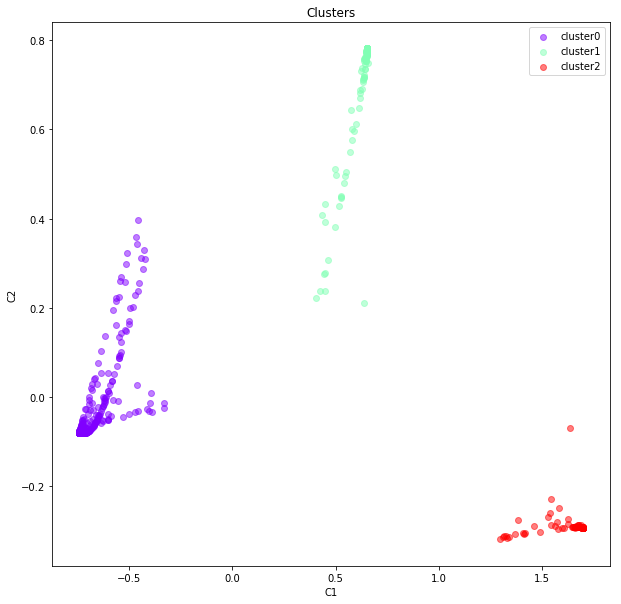

In [86]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
n_clusters = 3
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(10,10))
pdf = principalDf_dbscan.copy()
# plt.scatter(subset.C1, subset.C2)
for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.label == label] #subset is a dataframe including all the columns
    plt.scatter(subset.C1, subset.C2, c=color, label='cluster'+str(label),alpha=0.5) # plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('C1')
plt.ylabel('C2')

PARALLEL PLOT

In [87]:
XX_dfl.head(3)

,totfood,totalch,totclth,tothous,totfurn,tothlth,tottrsp,totcmnq,totrcre,toteduc,totmisc,label
0,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.284140,0.199687,2
1,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.284140,0.199687,2
2,-0.309691,-0.236916,-0.255200,-0.164006,-0.234674,-0.160486,-0.182042,-0.249690,-0.178124,-0.198115,-0.215703,0


In [88]:
ddd = XX_dfl.label

In [89]:
df = pd.read_csv('final_capstone_project_data.csv') # original data
df.drop(['Unnamed: 0','hid','region','rururb','TOTAL_EXP'], axis = 1, inplace = True)
df.head(2)

,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
0,9437.439453,0.0,1978.0,2569.800049,1128.790039,182.5,2248.399902,138.899994,55.25,1481.5,1081.459961
1,6990.479980,0.0,906.0,10808.799805,1693.709961,21.9,192.500000,370.399994,50.00,5079.0,260.200012


In [90]:
b1 = pd.merge(ddd, df, how='inner', left_index = True, right_index=True) # we are merging on the household id.


In [91]:
b1.head(4)

,label,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
0,2,9437.439453,0.0,1978.0,2569.800049,1128.790039,182.500000,2248.399902,138.899994,55.250000,1481.5,1081.459961
1,2,6990.479980,0.0,906.0,10808.799805,1693.709961,21.900000,192.500000,370.399994,50.000000,5079.0,260.200012
2,0,3079.566895,0.0,442.0,1240.099976,379.599976,29.200001,0.000000,146.000000,21.900002,827.0,932.660034
3,2,6542.259766,0.0,2435.0,1200.800049,580.959961,29.200001,2579.500000,567.700012,12.500000,1198.0,898.919983


In [92]:
b1.groupby('label').mean()

,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
label,,,,,,,,,,,
0,3667.370932,14.542541,655.454817,742.977288,309.075706,31.879222,420.006719,149.034261,83.936939,1171.337822,141.019321
1,7086.889629,373.569053,742.789712,658.137652,423.271500,205.307868,647.811045,180.181819,105.770703,1051.703190,202.121383
2,9597.291821,54.960748,2247.570768,2404.339304,1154.940254,185.995101,3110.407862,783.884044,616.412075,4702.824890,916.639694


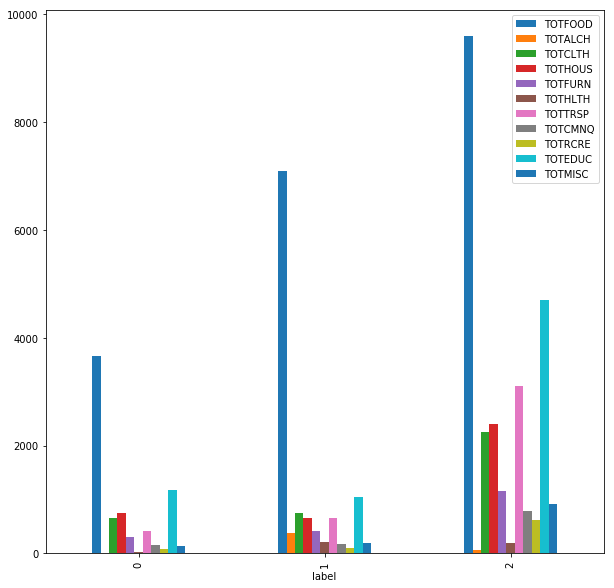

In [93]:
b1.groupby('label').mean().plot(kind='bar', figsize=(10,10))

No handles with labels found to put in legend.


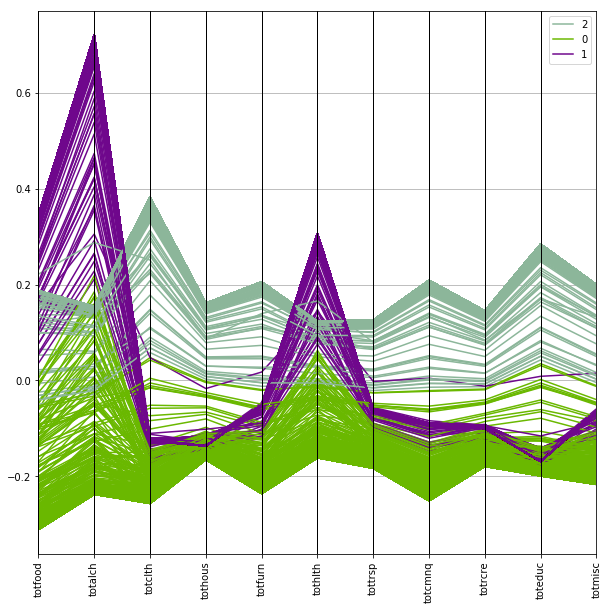

In [94]:
#parallelchord plot
import pandas
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(10,10))
plt.xticks(rotation='vertical')
plt.legend(loc='lower left')
parallel_coordinates(XX_dfl, 'label')
plt.show()

This resembles upper, middle  - purple and lower class

In [95]:
col_list= list(df)
b1['TOTAL_EXP'] = df[col_list].sum(axis=1)

In [96]:
b2 = b1[['label','TOTAL_EXP']]

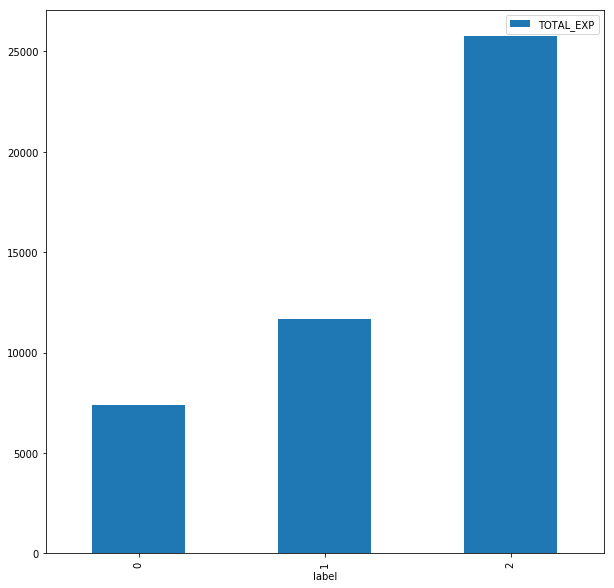

In [97]:
b2.groupby('label').mean().plot(kind='bar', figsize=(10,10))

We have it here, upper, lower and middle class

Counting the number of data points in each cluster

In [98]:
XX_dfl.label.value_counts()

0    5657
2    1964
1    1301
Name: label, dtype: int64

In [100]:
b1.to_csv('b11.csv')

DEC - deep learning + k means

In [101]:
#from keras_dec import DeepEmbeddingClustering
import numpy as np


USE DEC AS A FINCTION

In [102]:
'''
Keras implementation of deep embedder to improve clustering, inspired by:
"Unsupervised Deep Embedding for Clustering Analysis" (Xie et al, ICML 2016)

Definition can accept somewhat custom neural networks. Defaults are from paper.
'''
import sys
import numpy as np
import keras.backend as K
from keras.initializers import RandomNormal
from keras.engine.topology import Layer, InputSpec
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD
from sklearn.preprocessing import normalize
from keras.callbacks import LearningRateScheduler
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
if (sys.version[0] == 2):
    import cPickle as pickle
else:
    import pickle
import numpy as np

class ClusteringLayer(Layer):
    '''
    Clustering layer which converts latent space Z of input layer
    into a probability vector for each cluster defined by its centre in
    Z-space. Use Kullback-Leibler divergence as loss, with a probability
    target distribution.
    # Arguments
        output_dim: int > 0. Should be same as number of clusters.
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        alpha: parameter in Student's t-distribution. Default is 1.0.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    '''
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        # kmeans cluster centre locations
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DeepEmbeddingClustering(object):
    def __init__(self,
                 n_clusters,
                 input_dim,
                 encoded=None,
                 decoded=None,
                 alpha=1.0,
                 pretrained_weights=None,
                 cluster_centres=None,
                 batch_size=256,
                 **kwargs):

        super(DeepEmbeddingClustering, self).__init__()

        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.encoded = encoded
        self.decoded = decoded
        self.alpha = alpha
        self.pretrained_weights = pretrained_weights
        self.cluster_centres = cluster_centres
        self.batch_size = batch_size

        self.learning_rate = 0.1
        self.iters_lr_update = 20000
        self.lr_change_rate = 0.1

        # greedy layer-wise training before end-to-end training:

        self.encoders_dims = [self.input_dim, 500, 500, 2000, 10]

        self.input_layer = Input(shape=(self.input_dim,), name='input')
        dropout_fraction = 0.2
        init_stddev = 0.01

        self.layer_wise_autoencoders = []
        self.encoders = []
        self.decoders = []
        for i  in range(1, len(self.encoders_dims)):
            
            encoder_activation = 'linear' if i == (len(self.encoders_dims) - 1) else 'relu'
            encoder = Dense(self.encoders_dims[i], activation=encoder_activation,
                            input_shape=(self.encoders_dims[i-1],),
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros', name='encoder_dense_%d'%i)
            self.encoders.append(encoder)

            decoder_index = len(self.encoders_dims) - i
            decoder_activation = 'linear' if i == 1 else 'relu'
            decoder = Dense(self.encoders_dims[i-1], activation=decoder_activation,
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros',
                            name='decoder_dense_%d'%decoder_index)
            self.decoders.append(decoder)

            autoencoder = Sequential([
                Dropout(dropout_fraction, input_shape=(self.encoders_dims[i-1],), 
                        name='encoder_dropout_%d'%i),
                encoder,
                Dropout(dropout_fraction, name='decoder_dropout_%d'%decoder_index),
                decoder
            ])
            autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
            self.layer_wise_autoencoders.append(autoencoder)

        # build the end-to-end autoencoder for finetuning
        # Note that at this point dropout is discarded
        self.encoder = Sequential(self.encoders)
        self.encoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
        self.decoders.reverse()
        self.autoencoder = Sequential(self.encoders + self.decoders)
        self.autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))

        if cluster_centres is not None:
            assert cluster_centres.shape[0] == self.n_clusters
            assert cluster_centres.shape[1] == self.encoder.layers[-1].output_dim

        if self.pretrained_weights is not None:
            self.autoencoder.load_weights(self.pretrained_weights)

    def p_mat(self, q):
        weight = q**2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def initialize(self, X, save_autoencoder=False, layerwise_pretrain_iters=50000, finetune_iters=100000):
        if self.pretrained_weights is None:

            iters_per_epoch = int(len(X) / self.batch_size)
            layerwise_epochs = max(int(layerwise_pretrain_iters / iters_per_epoch), 1)
            finetune_epochs = max(int(finetune_iters / iters_per_epoch), 1)

            print('layerwise pretrain')
            current_input = X
            lr_epoch_update = max(1, self.iters_lr_update / float(iters_per_epoch))
            
            def step_decay(epoch):
                initial_rate = self.learning_rate
                factor = int(epoch / lr_epoch_update)
                lr = initial_rate / (10 ** factor)
                return lr
            lr_schedule = LearningRateScheduler(step_decay)

            for i, autoencoder in enumerate(self.layer_wise_autoencoders):
                if i > 0:
                    weights = self.encoders[i-1].get_weights()
                    dense_layer = Dense(self.encoders_dims[i], input_shape=(current_input.shape[1],),
                                        activation='relu', weights=weights,
                                        name='encoder_dense_copy_%d'%i)
                    encoder_model = Sequential([dense_layer])
                    encoder_model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
                    current_input = encoder_model.predict(current_input)

                autoencoder.fit(current_input, current_input, 
                                batch_size=self.batch_size, epochs=layerwise_epochs, callbacks=[lr_schedule])
                self.autoencoder.layers[i].set_weights(autoencoder.layers[1].get_weights())
                self.autoencoder.layers[len(self.autoencoder.layers) - i - 1].set_weights(autoencoder.layers[-1].get_weights())
            
            print('Finetuning autoencoder')
            
            #update encoder and decoder weights:
            self.autoencoder.fit(X, X, batch_size=self.batch_size, epochs=finetune_epochs, callbacks=[lr_schedule])

            if save_autoencoder:
                self.autoencoder.save_weights('autoencoder.h5')
        else:
            print('Loading pretrained weights for autoencoder.')
            self.autoencoder.load_weights(self.pretrained_weights)

        # update encoder, decoder
        # TODO: is this needed? Might be redundant...
        for i in range(len(self.encoder.layers)):
            self.encoder.layers[i].set_weights(self.autoencoder.layers[i].get_weights())

        # initialize cluster centres using k-means
        print('Initializing cluster centres with k-means.')
        if self.cluster_centres is None:
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            self.y_pred = kmeans.fit_predict(self.encoder.predict(X))
            self.cluster_centres = kmeans.cluster_centers_

        # prepare DEC model
        #self.DEC = Model(inputs=self.input_layer,
        #                 outputs=ClusteringLayer(self.n_clusters,
        #                                        weights=self.cluster_centres,
        #                                        name='clustering')(self.encoder))
        self.DEC = Sequential([self.encoder,
                             ClusteringLayer(self.n_clusters,
                                                weights=self.cluster_centres,
                                                name='clustering')])
        self.DEC.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
        return

    def cluster_acc(self, y_true, y_pred):
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max())+1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

    def cluster(self, X, y=None,
                tol=0.01, update_interval=None,
                iter_max=10000,
                save_interval=None,
                **kwargs):

        if update_interval is None:
            # 1 epochs
            update_interval = X.shape[0]/self.batch_size
        print('Update interval', update_interval)

        if save_interval is None:
            # 50 epochs
            save_interval = X.shape[0]/self.batch_size*50
        print('Save interval', save_interval)

        assert save_interval >= update_interval

        train = True
        iteration, index = 0, 0
        self.accuracy = []

        while train:
            sys.stdout.write('\r')
            # cutoff iteration
            if iter_max < iteration:
                print('Reached maximum iteration limit. Stopping training.')
                return self.y_pred

            # update (or initialize) probability distributions and propagate weight changes
            # from DEC model to encoder.
            if iteration % update_interval == 0:
                self.q = self.DEC.predict(X, verbose=0)
                self.p = self.p_mat(self.q)

                y_pred = self.q.argmax(1)
                delta_label = ((y_pred == self.y_pred).sum().astype(np.float32) / y_pred.shape[0])
                if y is not None:
                    acc = self.cluster_acc(y, y_pred)[0]
                    self.accuracy.append(acc)
                    print('Iteration '+str(iteration)+', Accuracy '+str(np.round(acc, 5)))
                else:
                    print(str(np.round(delta_label*100, 5))+'% change in label assignment')

                if delta_label < tol:
                    print('Reached tolerance threshold. Stopping training.')
                    train = False
                    continue
                else:
                    self.y_pred = y_pred

                for i in range(len(self.encoder.layers)):
                    self.encoder.layers[i].set_weights(self.DEC.layers[0].layers[i].get_weights())
                self.cluster_centres = self.DEC.layers[-1].get_weights()[0]

            # train on batch
            sys.stdout.write('Iteration %d, ' % iteration)
            if (index+1)*self.batch_size > X.shape[0]:
                loss = self.DEC.train_on_batch(X[index*self.batch_size::], self.p[index*self.batch_size::])
                index = 0
                sys.stdout.write('Loss %f' % loss)
            else:
                loss = self.DEC.train_on_batch(X[index*self.batch_size:(index+1) * self.batch_size],
                                               self.p[index*self.batch_size:(index+1) * self.batch_size])
                sys.stdout.write('Loss %f' % loss)
                index += 1

            # save intermediate
            if iteration % save_interval == 0:
                z = self.encoder.predict(X)
                pca = PCA(n_components=2).fit(z)
                z_2d = pca.transform(z)
                clust_2d = pca.transform(self.cluster_centres)
                # save states for visualization
                pickle.dump({'z_2d': z_2d, 'clust_2d': clust_2d, 'q': self.q, 'p': self.p},
                            open('c'+str(iteration)+'.pkl', 'wb'))
                # save DEC model checkpoints
                self.DEC.save('DEC_model_'+str(iteration)+'.h5')

            iteration += 1
            sys.stdout.flush()
        return

In [103]:
c = DeepEmbeddingClustering(n_clusters=3, input_dim=11)

In [104]:
xx = XX_df.values

In [105]:
c.initialize(xx, finetune_iters=1000, layerwise_pretrain_iters=1000)
#cl = c.cluster(xx, y=None)

layerwise pretrain
Epoch 1/29
8922/8922 [==============================] - 1s 138us/step - loss: 0.0418
Epoch 2/29
8922/8922 [==============================] - 0s 19us/step - loss: 0.0230
Epoch 3/29
8922/8922 [==============================] - 0s 33us/step - loss: 0.0084
Epoch 4/29
8922/8922 [==============================] - 0s 20us/step - loss: 0.0054
Epoch 5/29
8922/8922 [==============================] - 0s 23us/step - loss: 0.0032
Epoch 6/29
8922/8922 [==============================] - 0s 18us/step - loss: 0.0022
Epoch 7/29
8922/8922 [==============================] - 0s 30us/step - loss: 0.0020
Epoch 8/29
8922/8922 [==============================] - 0s 21us/step - loss: 0.0019
Epoch 9/29
8922/8922 [==============================] - 0s 25us/step - loss: 0.0018
Epoch 10/29
8922/8922 [==============================] - 0s 19us/step - loss: 0.0018
Epoch 11/29
8922/8922 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 12/29
8922/8922 [==============================]

In [42]:
cl = c.cluster(xx, y=None)

Update interval 34.8515625
Save interval 1742.578125
100.0% change in label assignment
Reached maximum iteration limit. Stopping training.


In [43]:
cl

array([2, 2, 1, ..., 1, 1, 1])

In [106]:
xx.shape

(8922, 11)

In [107]:
cl.shape

(8922,)

In [108]:
cl.max()

2

In [109]:
cl.min()

0

In [111]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xx, cl))

Silhouette Coefficient: 0.417


DEC DOES NOT IMPROVE THE CLUSTERING

We stick autoencoder + kmeans

DBSCAN

In [29]:
#df = pd.read_csv('XX_df.csv')
#df.drop(['Unnamed: 0'], axis = 1, inplace = True)
#df.head(2)

In [30]:
#XX = df.values # Define input variable

In [31]:
#import numpy as np
#from sklearn.cluster import DBSCAN
#from sklearn import metrics

In [32]:
# Compute DBSCAN - best model
#db = DBSCAN(eps=0.08, min_samples=10, metric='cosine').fit(XX) # we set minimum sample in each cluster to be 100
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#labels = db.labels_

HDBSCAN

We will use HDBSCAN to perform the clustering and compare the results to the results above

In [33]:
#!pip install hdbscan
#!pip install --upgrade --user numpy

In [34]:
#import hdbscan

In [35]:
#XX = pd.read_csv('XX_df.csv')
#XX.drop(['Unnamed: 0'], axis = 1, inplace = True)
#XX.head(2)

In [36]:
#xx = XX.values

In [37]:
# Compute HDBSCAN - best model
#hdb = hdbscan.HDBSCAN().fit(xx) # we do not manually specify eps or min_sample or a metric

In [38]:
#hdb.labels_

In [39]:
#n_clusters_ = hdb.labels_.max() + 1

In [40]:
#print('number of clusters is ', n_clusters_)

Number of clusters donot change after apply a deep learning model

Add a label column to the data

In [41]:
#XX['label'] = hdb.labels_
#XX.head()

PCA

PCA Projection normalised data to 2D

In [42]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)

#principalComponents = pca.fit_transform(xx)

#principalDf_hdbscan_norm = pd.DataFrame(data = principalComponents
 #            , columns = ['C1', 'C2'])

In [43]:
#principalDf_hdbscan_norm['label'] = XX.label

#principalDf_hdbscan_norm.head()

In [44]:
#condition = principalDf_hdbscan_norm.label != -1

#principalDf_hdbscan_norm = principalDf_hdbscan_norm[condition]

Counting the number of clusters in each label

In [45]:
#principalDf_hdbscan_norm.label.value_counts()

Now, lets visualize the clusters

In [46]:
#n_clusters = n_clusters_
#colors = cm.rainbow(np.linspace(0, 1, n_clusters))
#cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
#plt.figure(figsize=(10,10))
#pdf = principalDf_hdbscan_norm.copy()
# plt.scatter(subset.C1, subset.C2)
#for color, label in zip(colors, cluster_labels):
 #   subset = pdf[pdf.label == label] #subset is a dataframe including all the columns
  #  plt.scatter(subset.C1, subset.C2, c=color, label='cluster'+str(label),alpha=0.5) # plt.scatter(subset.horsepow, subset.mpg)
#plt.legend()
#plt.title('Clusters')
#plt.xlabel('C1')
#plt.ylabel('C2')

In [47]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#print("Silhouette Coefficient: %0.3f"
 #     % metrics.silhouette_score(xx, hdb.labels_))

Not a better silhouetter score...we stick to non deep learning hdbscan

DEC

In [34]:
XX = pd.read_csv('XX_df.csv')
XX.drop(['Unnamed: 0'], axis = 1, inplace = True)
XX.head(2)
xx = XX.values

In [70]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [71]:


"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='softmax', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=3))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='/resources/data'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
        
        #import numpy as np
        from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

        nmi = normalized_mutual_info_score
        ari = adjusted_rand_score


        def acc(y_true, y_pred):
            """
            Calculate clustering accuracy. Require scikit-learn installed

            # Arguments
            y: true labels, numpy.array with shape `(n_samples,)`
            y_pred: predicted labels, numpy.array with shape `(n_samples,)`

            # Return
            accuracy, in [0,1]
            """
            y_true = y_true.astype(np.int64)
            assert y_pred.size == y_true.size
            D = max(y_pred.max(), y_true.max()) + 1
            w = np.zeros((D, D), dtype=np.int64)
            for i in range(y_pred.size):
                w[y_pred[i], y_true[i]] += 1
            from sklearn.utils.linear_assignment_ import linear_assignment
            ind = linear_assignment(w.max() - w)
            return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred


# setting the hyper parameters
XX = pd.read_csv('XX_df.csv')
XX.drop(['Unnamed: 0'], axis = 1, inplace = True)
xx = XX.values
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = xx
batch_size = 600
maxiter = 2e4
tol = 0.001
save_dir = '/resources/data'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 5
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)



In [72]:
xx.shape

(8922, 11)

In [73]:
xx

array([[ 0.7147062 , -0.06061968,  0.6926981 , ...,  0.52842265,
         0.58180153,  0.6249986 ],
       [ 0.7147062 , -0.06061968,  0.6926981 , ...,  0.52842265,
         0.58180153,  0.6249986 ],
       [-0.27014586, -0.18519646, -0.22646184, ..., -0.18521814,
        -0.1672734 , -0.2139568 ],
       ...,
       [-0.27014711, -0.18519998, -0.22646235, ..., -0.18521892,
        -0.1672734 , -0.21395752],
       [-0.27014711, -0.18519998, -0.22646235, ..., -0.18521892,
        -0.16727337, -0.21395749],
       [-0.27014711, -0.18519998, -0.22646235, ..., -0.18521892,
        -0.16727337, -0.21395749]])

In [74]:
# prepare the DEC model
dec = DEC(dims=[xx.shape[-1], 500, 500, 2000, 11], n_clusters=3, init=init)

dec.pretrain(x=xx, y=None, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)



...Pretraining...
Epoch 1/5
8922/8922 [==============================] - 5s 554us/step - loss: 0.1036
Epoch 2/5
8922/8922 [==============================] - 4s 484us/step - loss: 0.1036
Epoch 3/5
8922/8922 [==============================] - 4s 486us/step - loss: 0.1036
Epoch 4/5
8922/8922 [==============================] - 4s 491us/step - loss: 0.1036
Epoch 5/5
8922/8922 [==============================] - 4s 488us/step - loss: 0.1036
Pretraining time:  23.15190887451172
Pretrained weights are saved to /resources/data/ae_weights.h5


In [75]:
###

In [76]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 11)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               6000      
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 11)                22011     
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 33        
Total params: 1,280,544
Trainable params: 1,280,544
Non-trainable params: 0
_________________________________________________________________


In [77]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')


In [78]:
#df.to_csv('/resources/data/dff.csv')

In [79]:
#train_history2 = dec.fit(xx, y=None, epochs=50, batch_size=1048, validation_data=(x_train, x_train))

In [85]:
y_pred = dec.fit(xx, None, tol=tol, maxiter=maxiter, batch_size=batch_size, update_interval=update_interval)


Update interval 200
Save interval 74.35
Initializing cluster centers with k-means.
saving model to: /resources/data/DEC_model_0.h5
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: /resources/data/DEC_model_final.h5


In [86]:
pred_val = dec.predict(xx) # this is x' = output of auto encoder
#pred_auto_train = encoder.predict(x_train) # this is x' = output of auto encoder

In [87]:
pred_val.shape

(8922,)

In [88]:
pred_val

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
pred_val.max()

0

In [92]:
kmeans_dl_dec = km.fit(pred_val)

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.